In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import numpy as np
from Allineamento import *

In [2]:
def projectDistZ(x1,x2,y1,y2,d12,z):
    mx = (x2-x1)/d12
    xProj = x1 + mx * z
    
    my = (y2-y1)/d12
    yProj = y1 + my * z
    
    return (xProj, yProj)

def get_theta_angles(x1, y1, x2, y2, d):
    import numpy as np
    thetaX = np.arctan((x2-x1)/d) #rad
    thetaY = np.arctan((y2-y1)/d) #rad
    return (thetaX, thetaY)

## define run

In [ ]:
run_number = 730156

d12 = 330 ## cm
d23 = 66.8
d1c = 330 + 53.2 #cm
dc3 = 10.7 
d1calo = d1c + 779.2 


range_chamber = ((0,10),(0,10))
bins2d = (100,100)
mycmap = 'jet'

opt_hist = {'histtype': 'step', 'lw': 1.5, 'alpha': 0.8}
opts_2d = { "cmap" : mycmap, "bins" : bins2d} # "norm" : mpl.colors.LogNorm()}

th_cherry1 = 20
th_cherry2 = 20

data_path =f'data/TB_T9_2025/run{run_number}.h5'
print('opening ', data_path) 
pos = []
phs = []
tmis =[]
qtots =[]
nclus = []
info_pluss =[]
with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
    print(hf.keys())
    hf["xpos"].shape
    keys = list(hf.keys())
    pos.append(np.array(hf['xpos']))
    phs.append(np.array(hf['digiPH'])) # from 24
    tmis.append(np.array(hf['digiTime'])) # from 24
    qtots.append(np.array(hf['qtot'])) # from 24
    nclus.append(np.array(hf['nclu'])) # from 24
    info_pluss.append(np.array(hf['info_plus']))
    #for k in hf.keys():
    #    comand = f'{k} = np.array(hf["{k}"])'
        # print(comand)
    #  exec(comand)
xpos = np.concatenate(pos,axis=0)
ph = np.concatenate(phs,axis=0)
tm = np.concatenate(tmis,axis=0)
qtot = np.concatenate(qtots,axis=0)
nclu = np.concatenate(nclus,axis=0)
info_plus = np.concatenate(info_pluss,axis=0)
print('xpos shape', xpos.shape)

x1 = xpos[:,1]
y1 = xpos[:,0]
x2 = xpos[:,2]
y2 = xpos[:,3]
x3 = xpos[:,4]
y3 = xpos[:,5]

Calibration = False
if Calibration:
    q = -25.84
    m = 323.4
    ph[:,2]=  (ph[:,2] - q)/m

xcry, ycry = projectDistZ(x1,x2,y1,y2,d12,d1c)
theta_x_in, theta_y_in = get_theta_angles(x1, y1, x2, y2, d12)
theta_x_out, theta_y_out = get_theta_angles(xcry, ycry, x3, y3, dc3)


ph_calo_photon = ph[:,2]
ph_cherry1 = ph[:,0]




opening  data/TB_T9_2025/run730147.h5
<KeysViewHDF5 ['digiBase', 'digiPH', 'digiTime', 'info_plus', 'nclu', 'qtot', 'xinfo', 'xpos']>
xpos shape (27369, 6)
[ 1  1  1 ... 83 83 83]


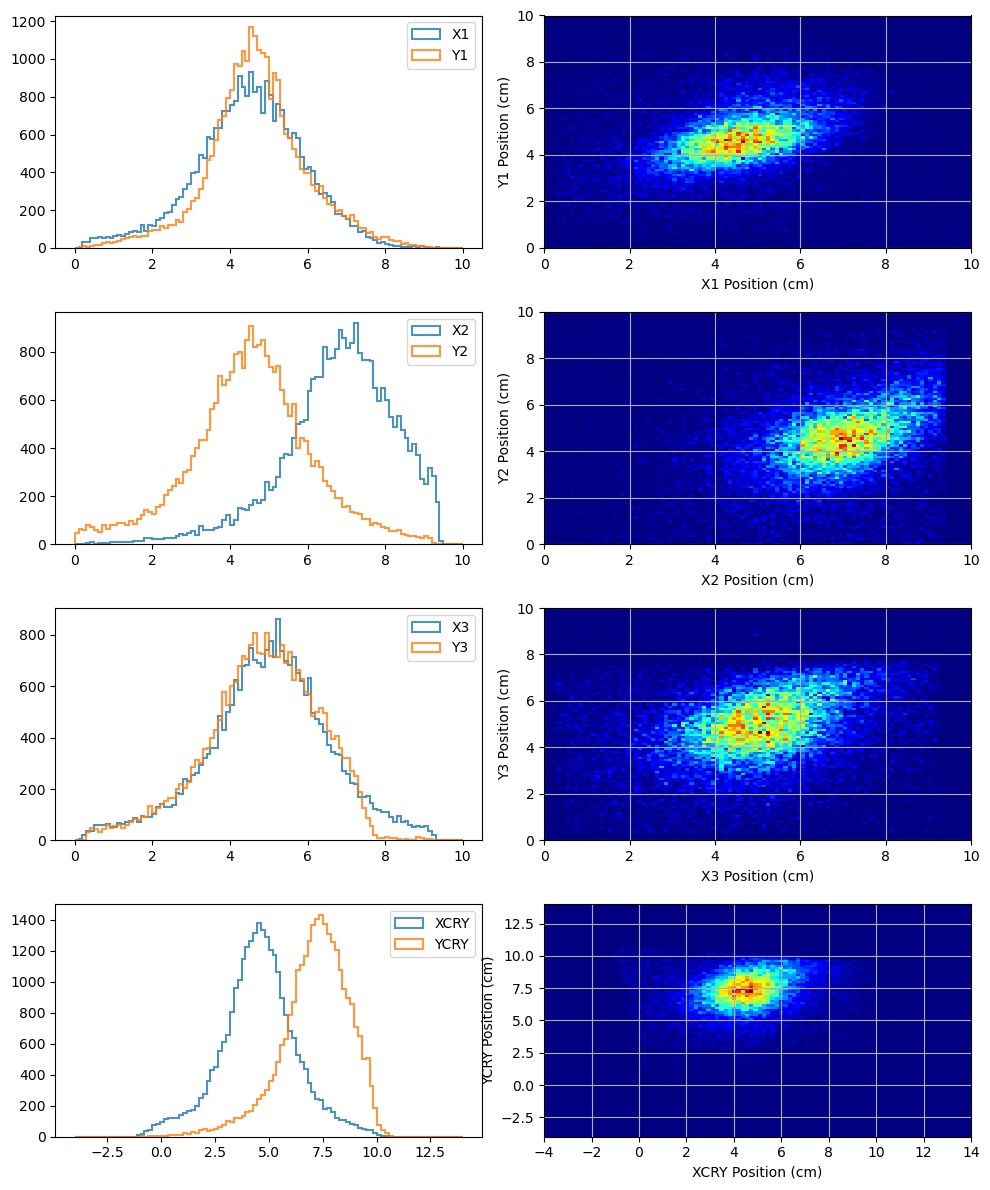

In [8]:
fig, ax = plt.subplots(4,2,figsize=(10, 12))
ax = ax.flatten()
ax[0].hist(xpos[:,1],range= range_chamber[0], bins=bins2d[0], label='X1', **opt_hist)
ax[0].hist(xpos[:,0],range= range_chamber[1], bins=bins2d[1], label='Y1', **opt_hist)
ax[0].legend()
ax[1].hist2d(xpos[:,1], xpos[:,0],range = range_chamber, **opts_2d)
ax[1].set_xlabel('X1 Position (cm)')
ax[1].set_ylabel('Y1 Position (cm)')
ax[1].grid()

ax[2].hist(xpos[:,3],range= range_chamber[0], bins=bins2d[0], label='X2', **opt_hist)
ax[2].hist(xpos[:,2],range= range_chamber[1], bins=bins2d[1], label='Y2', **opt_hist)
ax[2].legend()
ax[3].hist2d(xpos[:,3], xpos[:,2],range = range_chamber, **opts_2d)
ax[3].set_xlabel('X2 Position (cm)')
ax[3].set_ylabel('Y2 Position (cm)')
ax[3].grid()

ax[4].hist(xpos[:,4],range= range_chamber[0], bins=bins2d[0], label='X3', **opt_hist)
ax[4].hist(xpos[:,5],range= range_chamber[1], bins=bins2d[1], label='Y3', **opt_hist)
ax[4].legend()
ax[5].hist2d(xpos[:, 4], xpos[:, 5],range = range_chamber, **opts_2d)
ax[5].set_xlabel('X3 Position (cm)')
ax[5].set_ylabel('Y3 Position (cm)')
ax[5].grid()

ax[6].hist(xcry,range= (range_chamber[0][0]-4,range_chamber[0][1]+4), bins=bins2d[0], label='XCRY', **opt_hist)
ax[6].hist(ycry,range= (range_chamber[1][0]-4, range_chamber[1][1]+4), bins=bins2d[1], label='YCRY', **opt_hist)
ax[6].legend()
ax[7].hist2d(xcry, ycry,range =  ((range_chamber[0][0]-4,range_chamber[0][1]+4),(range_chamber[1][0]-4, range_chamber[1][1]+4)), **opts_2d)
ax[7].set_xlabel('XCRY Position (cm)')
ax[7].set_ylabel('YCRY Position (cm)')
ax[7].grid()

plt.tight_layout()
plt.show()

In [9]:
def Gauss(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit_theta(theta, ax, d):
    h_theta, b_thetas = np.histogram(theta, bins=100)
    b_theta = 0.5 * (b_thetas[1:] + b_thetas[:-1])

    sigma = np.std(theta)
    mu = np.mean(theta)
    a = np.max(h_theta)
    p0 = [a, mu, sigma]

    # Select data in ±3σ window around mean
    logi = (b_theta > (mu - 3*sigma)) & (b_theta < (mu + 3*sigma))
    x_fit = b_theta[logi]
    y_fit = h_theta[logi]

    # Remove zero entries to avoid sqrt(0) issues
    nonzero = y_fit > 0
    x_fit = x_fit[nonzero]
    y_fit = y_fit[nonzero]

    oP, pC = opt.curve_fit(
        Gauss, xdata=x_fit, ydata=y_fit,
        sigma=np.sqrt(y_fit), p0=p0, absolute_sigma=True
    )

    # Plot histogram and fit
    ax.hist(theta, bins=100, histtype='step', color='blue')
    ax.plot(x_fit, Gauss(x_fit, *oP), c='k', ls='--')

    # Offset computation
    mu_fit = oP[1]
    y_mu = Gauss(mu_fit, *oP)
    offset = d * np.tan(mu_fit)

    testo = f'$\\mu$ = {mu:.2e} mrad\n$\\sigma$ = {oP[2]:.2e} mrad\noffset = {offset:.2e} cm'
    print(f'$\\mu$ = {mu:.2f} mrad\n$\\sigma$ = {oP[2]:.2f} mrad\noffset = {offset:.2f} cm')

    ax.plot(mu_fit, y_mu, '*', color='k', ms=11, label=testo)
    ax.legend()

    return offset, oP


TypeError: The number of func parameters=3 must not exceed the number of data points=2

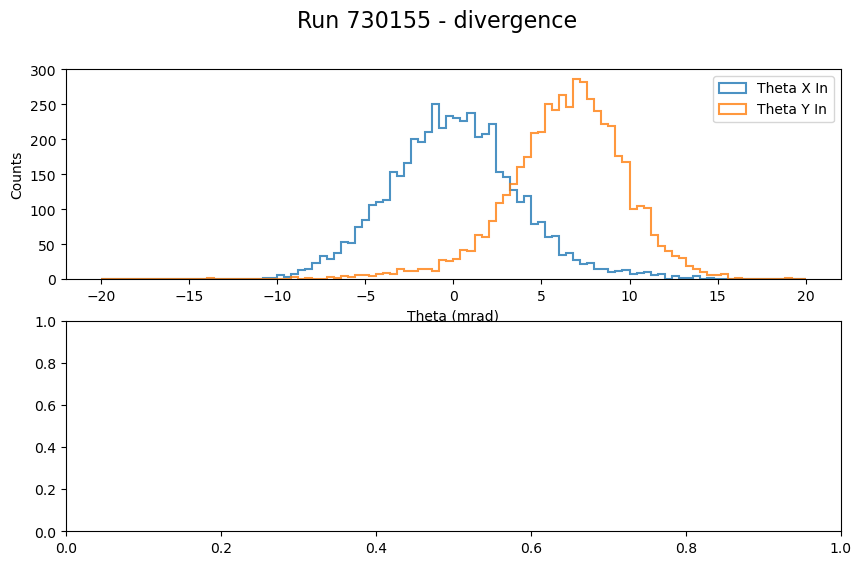

In [6]:
fig, ax = plt.subplots(2, figsize=(10, 6))
fig.suptitle(f'Run {run_number} - divergence ', fontsize=16)
ax[0].hist(theta_x_in*1e3, bins=100, range=(-20, 20), label='Theta X In', **opt_hist)
ax[0].hist(theta_y_in*1e3, bins=100, range=(-20, 20), label='Theta Y In', **opt_hist)
ax[0].legend()
ax[0].set_xlabel('Theta (mrad)')
ax[0].set_ylabel('Counts')

fit_theta(theta_x_in*1e3, ax[0], d12)
print()
# fit_theta(theta_y_in*1e3, ax[0], d12)
# print(max(theta_x_in)*1e3, max(theta_y_in)*1e3)

ax[1].hist(theta_x_out*1e3, bins=100, range=(-500, 500), label='Theta X Out', **opt_hist)
ax[1].hist(theta_y_out*1e3, bins=100, range=(-500, 500), label='Theta Y Out', **opt_hist)
ax[1].legend()
ax[1].set_xlabel('Theta (mrad)')
ax[1].set_ylabel('Counts')
ax[1].set_yscale('log')
ax[1].set_xlim(-500, 500)


plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(10, 6))
ax = ax.flatten()

label = ['Cherry XCET44', 'Cherry XCET48', 'LG fotoni fondo linea', 'LG desy TBC', 'Scinti']
ranges_Ph = [
    (0, 200),
    (0, 200),
    (0, 6) if Calibration else (0, 3000),
    (0, 5),
    (0, 12000)
]

for i in range(5):
    ax[i].hist(ph[:,i],range=ranges_Ph[i], bins=100, label=label[i], **opt_hist)
    ax[i].set_xlabel('ADC Counts')
    ax[i].set_ylabel('Entries')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_yscale('log')
for i in range(5):
    ax[i].hist(ph[:,i][ph_cherry1>th_cherry1],range=ranges_Ph[i], bins=100, label=label[i]+ 'logi_cherry', **opt_hist)
    ax[i].set_xlabel('ADC Counts')
    ax[i].set_ylabel('Entries')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_yscale('log')
ax[0].axvline(th_cherry1, color='red', linestyle='--', label='Threshold Cherry 1')
ax[1].axvline(th_cherry2, color='red', linestyle='--', label='Threshold Cherry 2')
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(10, 6))
ax = ax.flatten()

label = ['Cherry XCET44', 'Cherry XCET48', 'LG fotoni fondo linea', 'LG desy TBC', 'Scinti']
ranges_time = [(0, 1000), (0, 1000), (0, 1000), (0, 5), (0, 1000)]
for i in range(5):
    ax[i].hist(tm[:,i],range=ranges_time[i], bins=100, label=label[i], **opt_hist)
    ax[i].set_xlabel('Time Counts')
    ax[i].set_ylabel('Entries')
    ax[i].legend()
    ax[i].grid()
for i in range(5):
    ax[i].hist(tm[:,i][ph_cherry1>th_cherry1],range=ranges_time[i], bins=100, label=label[i]+ 'logi_cherry', **opt_hist)
    ax[i].set_xlabel('Time Counts')
    ax[i].set_ylabel('Entries')
    ax[i].legend()
    ax[i].grid()

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(10, 6))
ax = ax.flatten()

for i in range(5):
    ax[i].hist(tm[:,1]-tm[:,0],range=(-10,10),bins=20, label=label[i], **opt_hist)
    ax[i].set_xlabel('Time Difference (ns)')
    ax[i].legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10, 6))
ax[0].hist(qtot[:,0], range=(0, 10000), bins=100, label='Qtot X3', **opt_hist)
ax[0].hist(qtot[:,1], range=(0, 10000), bins=100, label='Qtot Y3', **opt_hist)
ax[0].set_xlabel('Charge (ADC Counts)')
ax[0].set_ylabel('Entries')
ax[0].legend()
ax[0].grid()
ax[1].hist(nclu[:,0], bins=20, label='N Clusters X3', **opt_hist)
ax[1].hist(nclu[:,1], bins=20, label='N Clusters Y3', **opt_hist)
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Entries')
ax[1].legend()
ax[1].grid()
plt.tight_layout()
plt.show()

## Correlazione Time Ph

In [ ]:
# hist 2d Ph[:,i] vs tm[:,i]
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
ax = ax.flatten()
for i in range(5):
    ax[i].hist2d(tm[:, i],ph[:, i], range=[ranges_time[i],ranges_Ph[i]],**opts_2d)
    ax[i].set_xlabel('Time Counts')
    ax[i].set_ylabel('ADC Counts')
    ax[i].set_title(f'Ph vs Time for {label[i]}')
    ax[i].grid()

ax[0].axhline(th_cherry1, color='red', linestyle='--', label='Threshold Cherry 1')
plt.tight_layout()
plt.show()

### Cluster and Qtot without logi

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(f'run - {run_number} -- Nclu S3 vs Cryspos')
ax = ax.flatten()
ax[0].set_title('Nclu X3 vs Xcry')
ax[0].hist2d(xcry, nclu[:,0],range =((-3,12),(0,20)),norm= mpl.colors.LogNorm(),**opts_2d)
ax[0].set_xlabel('Xcry Position (cm)')
ax[0].set_ylabel('N Clusters X3')
ax[1].set_title('Nclu X3 vs Ycry')
ax[1].hist2d(ycry, nclu[:,0],range =((-3,12),(0,20)),norm= mpl.colors.LogNorm(),**opts_2d)
ax[1].set_xlabel('Ycry Position (cm)')
ax[1].set_ylabel('N Clusters X3')
# ax[2].set_title('Nclu Y3 vs Xcry')
# ax[2].hist2d(xcry, nclu[:,1],range =((-3,12),(0,20)),**opts_2d)
# ax[2].set_xlabel('Xcry Position (cm)')
# ax[2].set_ylabel('N Clusters Y3')
# ax[3].set_title('Nclu Y3 vs Ycry')
# ax[3].hist2d(ycry, nclu[:,1],range =((-3,12),(0,20)),**opts_2d)
# ax[3].set_xlabel('Ycry Position (cm)')
# ax[3].set_ylabel('N Clusters Y3')

ax[2].set_title('Qtot X3 vs Xcry')
ax[2].hist2d(xcry, qtot[:,0],range =((-3,12),(0,2000)),**opts_2d)
ax[2].set_xlabel('Xcry Position (cm)')
ax[2].set_ylabel('Qtot X3')
ax[3].set_title('Qtot X3 vs Ycry')
ax[3].hist2d(ycry, qtot[:,0],range =((-3,12),(0,2000)),**opts_2d)
ax[3].set_xlabel('Ycry Position (cm)')
ax[3].set_ylabel('Qtot X3')

plt.tight_layout()
plt.show()

fig.savefig(f'plots/run{run_number}_cluster_vs_crystalpos.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12, 6))
fig.suptitle(f"run number {run_number} \n Tracce ricostruite sul piano del cristallo, pesate", fontsize = 16)

ax[0].set_title('nclus[0]')
hh_clu = ax[0].hist2d(x2, y2,range = ((-1,11),(-1,11)), weights = nclu[:,0], **opts_2d)
ax[0].set_xlabel('x2 Position (cm)')
ax[0].set_ylabel('y2 Position (cm)')
ax[0].grid()
plt.colorbar(hh_clu[3], ax=ax[0], label='nclus')

ax[1].set_title('qtot[0]')
hh_qtot = ax[1].hist2d(x2, y2,range = ((-1,11),(-1,11)), weights = qtot[:,0], **opts_2d)
ax[1].set_xlabel('x2 Position (cm)')
ax[1].set_ylabel('y2 Position (cm)')
ax[1].grid()
plt.colorbar(hh_qtot[3], ax=ax[1], label='qtot adc Counts')

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12, 6))
fig.suptitle(f"run number {run_number} \n Tracce ricostruite sul piano del cristallo, pesate", fontsize = 16)

ax[0].set_title('nclus[0]')
hh_clu = ax[0].hist2d(xcry, ycry,range = ((-1,11),(-1,11)), weights = nclu[:,0], **opts_2d)
ax[0].set_xlabel('xcry Position (cm)')
ax[0].set_ylabel('ycry Position (cm)')
ax[0].grid()
plt.colorbar(hh_clu[3], ax=ax[0], label='nclus')

ax[1].set_title('qtot[0]')
hh_qtot = ax[1].hist2d(xcry, ycry,range = ((-1,11),(-1,11)), weights = qtot[:,0], **opts_2d)
ax[1].set_xlabel('xcry Position (cm)')
ax[1].set_ylabel('ycry Position (cm)')
ax[1].grid()
plt.colorbar(hh_qtot[3], ax=ax[1], label='qtot adc Counts')

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,figsize=(8, 8))
fig.suptitle(f"run number {run_number} \n Tracce ricostruite sul piano del cristallo, pesate dal ph_calo_photon", fontsize = 16)
hh_x = ax.hist2d(x2, y2,range = ((-1,11),(-1,11)), weights = ph_calo_photon, **opts_2d)
ax.set_xlabel('x2 Position (cm)')
ax.set_ylabel('y2 Position (cm)')
ax.grid()
plt.colorbar(hh_x[3], ax=ax, label='ADC Counts')
plt.tight_layout()
plt.show()

### Cluster and Qtot with logi [ph_cherry1>th_cherry1]

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(f'run - {run_number} -- Nclu S3 vs Cryspos [LOGI CHERRY ON]')
ax = ax.flatten()
ax[0].set_title('Nclu X3 vs Xcry')
ax[0].hist2d(xcry[ph_cherry1>th_cherry1], nclu[:,0][ph_cherry1>th_cherry1],range =((-3,12),(0,20)),norm= mpl.colors.LogNorm(),**opts_2d)
ax[0].set_xlabel('Xcry Position (cm)')
ax[0].set_ylabel('N Clusters X3')
ax[1].set_title('Nclu X3 vs Ycry')
ax[1].hist2d(ycry[ph_cherry1>th_cherry1], nclu[:,0][ph_cherry1>th_cherry1],range =((-3,12),(0,20)),norm= mpl.colors.LogNorm(),**opts_2d)
ax[1].set_xlabel('Ycry Position (cm)')
ax[1].set_ylabel('N Clusters X3')


ax[2].set_title('Qtot X3 vs Xcry')
ax[2].hist2d(xcry[ph_cherry1>th_cherry1], qtot[:,0][ph_cherry1>th_cherry1],range =((-3,12),(0,2000)),**opts_2d)
ax[2].set_xlabel('Xcry Position (cm)')
ax[2].set_ylabel('Qtot X3')
ax[3].set_title('Qtot X3 vs Ycry')
ax[3].hist2d(ycry[ph_cherry1>th_cherry1], qtot[:,0][ph_cherry1>th_cherry1],range =((-3,12),(0,2000)),**opts_2d)
ax[3].set_xlabel('Ycry Position (cm)')
ax[3].set_ylabel('Qtot X3')

plt.tight_layout()
plt.show()

fig.savefig(f'plots/run{run_number}_cluster_vs_crystalpos.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12, 6))
fig.suptitle(f"run number {run_number} \n Tracce ricostruite sul piano del cristallo, pesate [LOGI CHERRY ON]", fontsize = 16)

ax[0].set_title('nclus[0]')
hh_clu = ax[0].hist2d(x2[ph_cherry1>th_cherry1], y2[ph_cherry1>th_cherry1],range = ((-1,11),(-1,11)), weights = nclu[:,0][ph_cherry1>th_cherry1], **opts_2d)
ax[0].set_xlabel('x2 Position (cm)')
ax[0].set_ylabel('y2 Position (cm)')
ax[0].grid()
plt.colorbar(hh_clu[3], ax=ax[0], label='nclus')

ax[1].set_title('qtot[0]')
hh_qtot = ax[1].hist2d(x2[ph_cherry1>th_cherry1], y2[ph_cherry1>th_cherry1],range = ((-1,11),(-1,11)), weights = qtot[:,0][ph_cherry1>th_cherry1], **opts_2d)
ax[1].set_xlabel('x2 Position (cm)')
ax[1].set_ylabel('y2 Position (cm)')
ax[1].grid()
plt.colorbar(hh_qtot[3], ax=ax[1], label='qtot adc Counts')

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(8, 10))
fig.suptitle(f"run number {run_number} \n Tracce ricostruite sul piano del cristallo, pesate dal ph_calo_photon [LOGI CHERRY ON]", fontsize = 16)
hh_x = ax[0].hist2d(x1[ph_cherry1>th_cherry1], y1[ph_cherry1>th_cherry1],range = ((-1,11),(-1,11)), weights = ph_calo_photon[ph_cherry1>th_cherry1], **opts_2d)
ax[0].set_xlabel('x1 Position (cm)')
ax[0].set_ylabel('y1 Position (cm)')
ax[0].grid()

ax[0].axvline(x = 3, color='red', linestyle='--')
ax[0].axvline(x = 6.5, color='red', linestyle='--')
ax[0].axhline(y = 3, color='red', linestyle='--')
ax[0].axhline(y = 6.25, color='red', linestyle='--')
plt.colorbar(hh_x[3], ax=ax[0], label='ADC Counts')
hh_x = ax[1].hist2d(x2[ph_cherry1>th_cherry1], y2[ph_cherry1>th_cherry1],range = ((-1,11),(-1,11)), weights = ph_calo_photon[ph_cherry1>th_cherry1], **opts_2d)
ax[1].set_xlabel('x2 Position (cm)')
ax[1].set_ylabel('y2 Position (cm)')
ax[1].grid()

ax[1].axvline(x = 3.85, color='red', linestyle='--')
ax[1].axvline(x = 4.7, color='lime', linestyle='--')
ax[1].axvline(x = 5.4, color='red', linestyle='--')
ax[1].axhline(y = 6.45, color='red', linestyle='--')
ax[1].axhline(y = 7.2, color='lime', linestyle='--')
ax[1].axhline(y = 8, color='red', linestyle='--')
plt.colorbar(hh_x[3], ax=ax[1], label='ADC Counts')
plt.tight_layout()
plt.show()

### calculate on which strip cut

In [ ]:
def cm_to_strip(position_cm):
    pitch_um = 242  # microns
    # position_cm = 9.3  # for example, 2.0 cm

    strip_number = position_cm * 1e4 / pitch_um
    strip_number = int(strip_number)  # or use np.round(strip_number)

    print(f"Position {position_cm} cm corresponds to strip number {strip_number}")


In [ ]:
# ##CHECK
# cm_to_strip(0)
# cm_to_strip(9.3/2)
# print(384/2)
# cm_to_strip(9.3)


In [ ]:
# x = 3.85
# x = 5.4
# y = 6.45
# y = 8
print('#### X2 CUT ####')
cm_to_strip(3.8)
cm_to_strip(5.2)
print('\n#### Y2 CUT ####')
cm_to_strip(6.45)
cm_to_strip(8)

In [ ]:
# x = 2.75
# x = 6.5
# y = 3
# y = 6.25

print('#### X1 CUT ####')
cm_to_strip(3)
cm_to_strip(6.5)
print('\n#### Y1 CUT ####')
cm_to_strip(3)
cm_to_strip(6.25)